### MNIST(80) revised augmentation -> CIFAR (5/epocaMNIST)
size = 224
xresnet34deep, pretrained=true
fit
5% do dataset
fp16

In [1]:
from fastai.vision.all import *
from datetime import datetime
import torch
torch.cuda.is_available()

True

In [2]:
path = Path('/home/fredguth/.fastai/data/cifar10_mnist')

In [3]:
def label_func(f):
    return (str(f).split("_y")[1:][0][0])

def noise_func(f):
    return (str(f).split("_n")[1:][0][0])

In [4]:
def get_dls(task="CIFAR", size=64):
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   splitter  = RandomSubsetSplitter(train_sz=0.05, valid_sz=0.05, seed=42),
                   get_items = get_image_files,
                   get_y = label_func if (task == 'CIFAR') else noise_func,
                   batch_tfms= [*aug_transforms(size=size, min_scale=0.75, do_flip=False, pad_mode="zeros"), Normalize],
                   n_inp     = 1 )
    return dblock.dataloaders(path, num_workers=4)

In [5]:
class HeadBodyNetwork(Module):
    def __init__(self, head, body):
        self.head = head
        self. body = body
    def forward(self, x):
        return self.head(self.body(x))

In [6]:
def headbody_splitter(m): return L(m.head, m.body).map(params)

In [7]:
class RunMNIST(Callback):
    def after_epoch(self):  
        epoch = self.epoch
        backbone = copy(self.learn.model[0])
        head =  create_head(num_features_model(backbone),10)
        net = HeadBodyNetwork(head=head, body=backbone)
        l =Learner(
                           dls=get_dls(task="CIFAR", size=32), 
                           model=net,
                           splitter=headbody_splitter,
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex6/cifar_after_mnist_e{epoch}.csv", append=True)])
        l.freeze()
        l.fit(3,0.002)

In [154]:
m = cnn_learner(dls=get_dls(task="CIFAR", size=224), arch=resnet18, pretrained = False).model

In [156]:
n = nn.Sequential(m, create_head(num_features_model(m), 64))

In [157]:
n

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, mome

In [ ]:
backbone = copy(self.learn.model[0])
head =  create_head(num_features_model(backbone),10)
net = HeadBodyNetwork(head=head, body=backbone)
l =Learner(
                   dls=get_dls(task="CIFAR", size=32), 
                   model=net,
                   splitter=headbody_splitter,
                   loss_func=F.cross_entropy, 
                   metrics=accuracy, 
                   cbs=[CSVLogger(fname=f"results/ex6/cifar_after_mnist_e{epoch}.csv", append=True)])
l.freeze()
l.fit(3,0.002)

In [8]:
mnist_learner= cnn_learner(dls=get_dls(task="MNIST", size=224), 
                           arch=xresnet34_deep, 
                           pretrained=True, 
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex6/mnist.csv", append=True), RunMNIST]
                          )

In [9]:
mnist_learner.to_fp16()

In [10]:
mnist_learner.fit(80,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,3.325441,2.337925,0.184800,00:22
1,3.074176,3.581748,0.159600,00:24
2,2.830142,2.076286,0.334400,00:24
3,2.391688,1.567456,0.484800,00:26
4,1.897374,1.357238,0.579600,00:26
5,1.474358,1.294341,0.658800,00:27
6,1.161204,0.850803,0.747600,00:26
7,0.963261,1.226316,0.692800,00:27
8,0.786502,0.672336,0.798800,00:28
9,0.666951,0.301347,0.899600,00:31


epoch,train_loss,valid_loss,accuracy,time
0,2.093993,2.106951,0.263200,00:04
1,1.918609,1.883887,0.340400,00:03
2,1.772595,2.111602,0.318800,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.996244,1.905706,0.330400,00:03
1,1.774173,1.732321,0.410000,00:03
2,1.631625,1.674459,0.424400,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.525540,1.521026,0.471600,00:04
1,1.440050,1.892303,0.413600,00:04
2,1.390551,1.558542,0.471200,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.325759,1.605178,0.468400,00:04
1,1.226590,2.477596,0.364400,00:04
2,1.141247,1.950622,0.440000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.133984,1.655427,0.448400,00:04
1,1.082654,1.804525,0.439200,00:04
2,0.991709,1.647901,0.501600,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.975838,1.436809,0.525200,00:04
1,0.897816,1.603040,0.514800,00:04
2,0.812688,1.524266,0.532000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.783408,1.524328,0.509200,00:04
1,0.708197,1.835251,0.501200,00:04
2,0.652592,1.548237,0.541200,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.627182,1.432515,0.554000,00:04
1,0.571915,2.004958,0.478400,00:04
2,0.539228,1.553041,0.549600,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.596039,1.413786,0.558800,00:04
1,0.519086,1.354612,0.589200,00:04
2,0.466325,1.802183,0.519200,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.481458,1.672980,0.532400,00:05
1,0.427254,1.575045,0.536400,00:05
2,0.378284,1.543428,0.550800,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.424932,1.577947,0.550000,00:05
1,0.387736,1.602615,0.548000,00:05
2,0.359097,1.558135,0.568000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.375656,1.675829,0.528800,00:03
1,0.329044,1.705182,0.540800,00:03
2,0.325021,1.673133,0.546000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.348645,1.729730,0.530800,00:05
1,0.292880,1.786097,0.548800,00:05
2,0.308968,1.748656,0.536000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.333660,1.665533,0.537600,00:05
1,0.277220,1.587838,0.562800,00:06
2,0.247395,1.768184,0.535600,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.279145,1.763041,0.524400,00:04
1,0.261924,1.789905,0.546400,00:03
2,0.261897,1.799484,0.554800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.262316,1.594218,0.556400,00:04
1,0.224364,1.650954,0.561600,00:05
2,0.216838,2.078052,0.487600,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.231934,1.743106,0.535600,00:05
1,0.220092,1.753623,0.534000,00:05
2,0.212456,1.695692,0.571200,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.263770,1.638122,0.545600,00:03
1,0.215798,1.754763,0.549600,00:04
2,0.205375,1.803930,0.540800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.242403,1.697615,0.545600,00:05
1,0.211228,1.806165,0.546000,00:05
2,0.205674,1.802641,0.526800,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.206754,1.654759,0.556800,00:05
1,0.195887,1.721234,0.536800,00:03
2,0.191641,1.706949,0.549200,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.204154,1.848151,0.534400,00:05
1,0.188993,1.713720,0.562000,00:05
2,0.168652,1.806297,0.552000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.199921,1.713923,0.556400,00:05
1,0.176263,1.599133,0.576800,00:03
2,0.164421,1.682061,0.577200,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.178672,1.893698,0.519200,00:05
1,0.163207,1.915984,0.529600,00:05
2,0.164438,1.839875,0.556400,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.176683,1.740712,0.550400,00:05
1,0.162746,1.763176,0.558400,00:05
2,0.160947,1.669267,0.582000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.183967,1.686657,0.553600,00:05
1,0.159976,1.737484,0.571200,00:03
2,0.150728,1.750637,0.570800,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.122383,1.719430,0.552400,00:04
1,0.135406,1.826539,0.552400,00:04
2,0.147395,1.990204,0.543600,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.175096,1.702185,0.559200,00:04
1,0.184669,1.985849,0.527200,00:05
2,0.172742,1.769609,0.567600,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.154227,1.680973,0.558000,00:05
1,0.156100,1.702645,0.569200,00:05
2,0.162169,1.770282,0.560000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.160780,1.745324,0.543600,00:03
1,0.128550,1.798810,0.556000,00:04
2,0.143681,1.829294,0.561600,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.140110,1.565207,0.576400,00:04
1,0.137588,1.718997,0.578000,00:04
2,0.122624,1.845154,0.558000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.114309,1.757830,0.552400,00:06
1,0.128762,1.945207,0.541200,00:05
2,0.137479,1.927213,0.549600,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.134387,1.762066,0.551600,00:05
1,0.133727,1.801389,0.564800,00:05
2,0.124419,1.783015,0.573200,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.119886,1.741619,0.558000,00:04
1,0.125074,1.811815,0.560800,00:03
2,0.127566,1.766320,0.583200,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.148379,1.785891,0.545600,00:06
1,0.131390,1.891695,0.548800,00:05
2,0.113705,1.910197,0.551600,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.144179,1.764296,0.554800,00:04
1,0.126876,1.843144,0.558400,00:03
2,0.108877,1.736857,0.566800,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.108912,1.730398,0.546000,00:04
1,0.122642,1.755607,0.574000,00:04
2,0.112923,1.883386,0.552400,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.107406,1.792611,0.551200,00:05
1,0.115887,1.916597,0.538400,00:05
2,0.109636,1.910334,0.553200,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.097933,1.802593,0.556400,00:05
1,0.117202,1.728660,0.574000,00:05
2,0.110367,1.865391,0.560400,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.115053,1.817931,0.550400,00:05
1,0.112940,1.808894,0.570800,00:03
2,0.112269,1.959382,0.547600,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.128212,1.777874,0.554000,00:04
1,0.109772,1.906981,0.566800,00:04
2,0.109550,1.833202,0.573600,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.124111,1.767292,0.546800,00:05
1,0.106076,1.951087,0.554800,00:05
2,0.095438,1.919483,0.558800,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.088494,2.012695,0.516800,00:04
1,0.118341,1.897179,0.556800,00:04
2,0.093800,1.844802,0.566400,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.125013,1.683794,0.570400,00:04
1,0.114916,1.886093,0.556400,00:04
2,0.090989,1.884097,0.558000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.102350,1.748058,0.565600,00:04
1,0.088409,1.896103,0.554000,00:04
2,0.095434,1.807295,0.579200,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.104513,1.842529,0.550800,00:04
1,0.111194,1.761614,0.574000,00:04
2,0.094146,1.887255,0.570800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.089463,1.777323,0.565600,00:04
1,0.099224,1.909326,0.565200,00:04
2,0.088812,1.745529,0.582800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.109449,1.730605,0.565200,00:04
1,0.088063,1.730292,0.594000,00:04
2,0.098228,1.874118,0.560800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.106693,1.841707,0.553200,00:04
1,0.089254,1.783576,0.584000,00:04
2,0.099531,2.052870,0.543200,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.098852,1.693181,0.570800,00:04
1,0.093801,1.893208,0.554400,00:04
2,0.091487,1.926381,0.554800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.099823,1.813316,0.558400,00:04
1,0.097443,1.914807,0.561200,00:04
2,0.086652,1.859357,0.568800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.108482,1.726484,0.576400,00:04
1,0.085821,1.793885,0.570800,00:04
2,0.090438,1.823603,0.572000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.083730,1.749353,0.570400,00:04
1,0.082622,2.154759,0.532800,00:04
2,0.086990,1.928518,0.556000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.068694,1.864883,0.542000,00:04
1,0.082081,2.015726,0.546800,00:04
2,0.077465,1.883697,0.568400,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.070544,1.949337,0.552400,00:05
1,0.087105,1.958360,0.565200,00:05
2,0.089134,1.929046,0.564800,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.099286,1.973663,0.540400,00:04
1,0.087073,1.824051,0.568000,00:03
2,0.087539,1.827495,0.579600,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.091760,1.855080,0.559600,00:04
1,0.085492,1.790029,0.576000,00:04
2,0.081568,1.911190,0.560800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.093719,1.767271,0.564400,00:05
1,0.086940,2.001090,0.557200,00:05
2,0.070122,1.954850,0.572800,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.074792,1.721020,0.577600,00:05
1,0.076973,1.974742,0.547200,00:05
2,0.089271,1.932703,0.567200,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.094829,1.673334,0.574000,00:03
1,0.078670,1.884131,0.568400,00:03
2,0.084465,1.921535,0.564000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.085370,1.866806,0.560000,00:04
1,0.068807,1.887207,0.570400,00:04
2,0.079993,2.069390,0.552000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.096509,1.852006,0.552400,00:04
1,0.084628,1.862806,0.569200,00:04
2,0.066784,2.021034,0.560800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.094731,1.955442,0.542400,00:04
1,0.080601,1.910913,0.568000,00:04
2,0.066389,1.821489,0.584000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.089820,1.739897,0.582800,00:05
1,0.067483,1.810638,0.573200,00:05
2,0.066428,2.008189,0.562400,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.075994,1.906386,0.550400,00:05
1,0.077175,1.978010,0.565200,00:03
2,0.070381,2.014058,0.552800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.090589,1.784292,0.567600,00:04
1,0.070106,1.881018,0.558800,00:04
2,0.062652,1.954622,0.569200,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.094019,1.771828,0.572000,00:04
1,0.064335,1.844175,0.577600,00:04
2,0.065202,1.904816,0.550800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.064429,1.855668,0.555600,00:04
1,0.066057,2.259432,0.526400,00:05
2,0.072150,1.918958,0.580400,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.074534,1.907253,0.550800,00:05
1,0.067606,1.945781,0.552400,00:06
2,0.066941,1.991130,0.566000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.076009,1.814083,0.557600,00:03
1,0.064964,2.022291,0.550000,00:04
2,0.082768,2.009426,0.547200,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.082296,1.865166,0.546000,00:04
1,0.081112,1.890294,0.575600,00:04
2,0.072004,1.953668,0.559600,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.062748,1.889504,0.555200,00:05
1,0.072564,2.056810,0.550000,00:05
2,0.077083,1.947144,0.563200,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.070053,1.790911,0.566400,00:03
1,0.065710,1.840790,0.565600,00:03
2,0.078511,1.965487,0.561600,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.088228,1.880678,0.548000,00:04
1,0.072672,1.994446,0.553600,00:04
2,0.072115,1.961871,0.552400,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.070056,1.941166,0.552000,00:05
1,0.068509,1.947431,0.567600,00:05
2,0.074504,1.968327,0.565200,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.073090,1.940882,0.541600,00:06
1,0.080645,1.926032,0.567200,00:06
2,0.072903,1.909983,0.568800,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.073314,1.924243,0.554800,00:05
1,0.065858,1.989333,0.562400,00:05
2,0.064410,2.019842,0.560400,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.072886,1.843245,0.556000,00:03
1,0.066080,1.946602,0.570400,00:03
2,0.058608,1.891953,0.576000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.058449,1.828641,0.563200,00:04
1,0.066088,2.007042,0.554800,00:04
2,0.070995,1.877031,0.572800,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.075674,1.814138,0.557200,00:04
1,0.065492,2.146702,0.538800,00:04
2,0.070581,1.980159,0.551600,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.074573,2.019051,0.527200,00:04
1,0.083088,2.016879,0.553600,00:04
2,0.071450,1.943800,0.560800,00:04


In [11]:
import pandas as pd
import glob

In [12]:
!pwd

/home/fredguth/unb/cifar_mnist


In [24]:
all_files = glob.glob("/home/fredguth/unb/cifar_mnist/results/ex6/cifar*.csv")

In [25]:
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [102]:
frame = pd.concat(li, axis=0, ignore_index=True)

In [103]:
cifar_results = frame.loc[frame['epoch'] == 2]

In [104]:
cifar_results = cifar_results.reset_index().drop(columns=['index', 'epoch'])

In [105]:
df = pd.read_csv("/home/fredguth/unb/cifar_mnist/results/ex6/mnist.csv", index_col=None, header=0)

In [106]:
result = pd.concat([cifar_results['valid_loss'], df['valid_loss']], axis=1, keys=['CIFAR', 'MNIST'])

In [107]:
df.to_excel("/home/fredguth/unb/cifar_mnist/results/ex6/mnist.xlsx")

In [108]:
cifar_results.to_excel("results/ex6/ex6_cifar_results.xlsx")

In [109]:
result.to_excel("/home/fredguth/unb/cifar_mnist/results/ex6/ex6.xlsx")

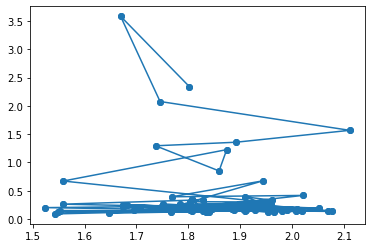

In [110]:
plt.scatter(x=result['CIFAR'].tolist(), y=result['MNIST'].tolist())
plt.plot(result['CIFAR'].tolist(), result['MNIST'].tolist(), '-o')
plt.show()

In [126]:
a, b= (result['CIFAR'].tolist(), result['MNIST'].tolist())

In [112]:
from matplotlib.collections import LineCollection

In [128]:
x = np.array(a)
y = np.array(b)
x  = np.array([ (i - x.min())/x.max() for i in x])
y  = np.array([ (i - y.min())/y.max() for i in y])
x  = np.array([ x.max()-i  for i in x])
y  = np.array([ y.max()-i  for i in y])

In [130]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

(0.0, 0.9744331502355731)

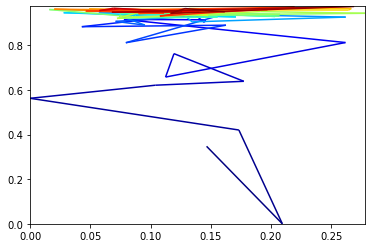

In [133]:
lc = LineCollection(segments, colors=linecolors)
fig1 = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

In [145]:

result = pd.concat([cifar_results['accuracy'], df['accuracy']], axis=1, keys=['CIFAR', 'MNIST'])

In [146]:
a, b= (result['CIFAR'].tolist(), result['MNIST'].tolist())

In [147]:
x = np.array(a)
y = np.array(b)
x  = np.array([ (i - x.min())/x.max() for i in x])
y  = np.array([ (i - y.min())/y.max() for i in y])
# x  = np.array([ x.max()-i  for i in x])
# y  = np.array([ y.max()-i  for i in y])

In [148]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

(0.0, 0.8358700092833437)

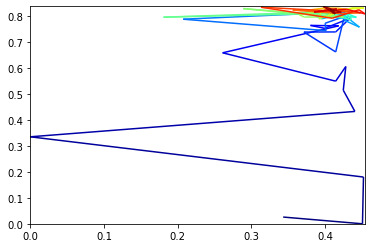

In [149]:
lc = LineCollection(segments, colors=linecolors)
fig1 = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())